In [1]:
import torch
from torch.nn import functional as F
from config import *
from encoder import Encoder
from modules import LLM

In [2]:
def get_loss_lr(log_file):
    with open(log_file) as f:
        lines = f.readlines()

    losses = []
    lrs = []
    for line in lines:
        step = int(line.split()[0][4:-1])
        loss = float(line.split()[1][5:])
        lr = float(line.split()[3][3:])
        if len(losses) > step - 1:
            losses[step - 1] = loss
            lrs[step - 1] = lr
        else:
            losses.append(loss)
            lrs.append(lr)
    return losses, lrs

In [3]:
import matplotlib.pyplot as plt

2.9140910506248474


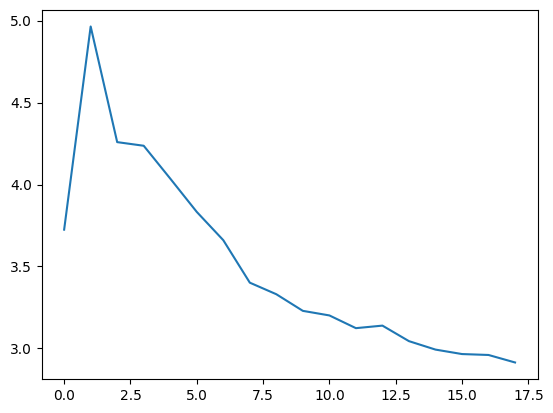

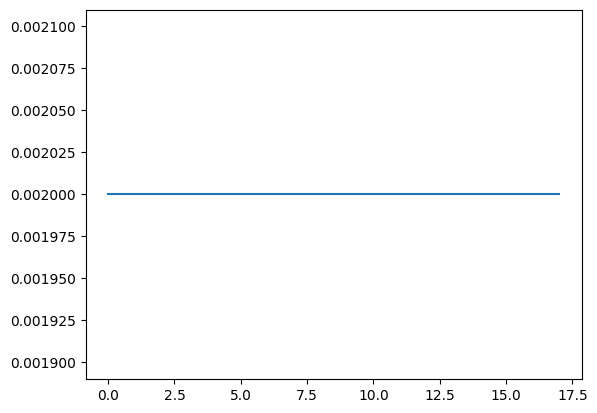

In [4]:
losses, lrs = get_loss_lr("finetune-losses.log")
print(min(losses))
plt.plot(losses)
plt.show()
plt.plot(lrs)
plt.show()

In [5]:
from dataloader import BinaryDataset, collate_fn
from torch.utils.data import DataLoader

loader = DataLoader(
    BinaryDataset(PRETRAIN_DATA, MAX_LENGTH),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)
encoder = Encoder.from_path("encoder.json")

In [ ]:
llm = LLM(encoder.vocab_size, MODEL_DIM, MAX_LENGTH, N_HEADS, N_BLOCKS, 0).to("cuda")
# sd = torch.load(PRETRAINED_STATE_DICT_PATH)
# llm.load_state_dict(sd)
llm.compile()

/tmp/ipykernel_3939/1622220568.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(PRETRAINED_STATE_DICT_PATH)


In [7]:
length = MAX_LENGTH
for x, y, n_tokens in loader:
    x = F.pad(x.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    y = F.pad(y.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    break

In [8]:
torch.set_float32_matmul_precision("high")
logits = llm(x)
print(loss := F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1)))

tensor(4.1951, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
out = logits[0].argmax(dim=-1).tolist()[MAX_LENGTH - length:]
print(encoder.decode(x[0].tolist()))
print(encoder.decode(y[0].tolist()))
print(encoder.decode(out))

It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing. 
  
 There’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list. 
  
 Concept 
  
 Working over the theme was probably one of the hardest tasks I had to face. 
  
 Originally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it. 
  
 In the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge.

In [10]:
loss.backward()

In [11]:
SPECIAL_TOKENS_IDS

{'<pad>': 20818, '<eos>': 20819, '<ins>': 20820, '</ins>': 19428}